# MNIST classification with a Convolutional Neural Network (CNN)

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from timeit import default_timer as timer

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(0))
else:
    device = 'cpu'
print('Using device:\t', device)

Using device:	 cpu


# MNIST dataset

## Preparing the data

### Defining the transformations

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=0.5, std=0.5)])

### Loading the data

In [4]:
ds_train = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

ds_test = torchvision.datasets.MNIST(root='./data', train=False,
                                          download=True, transform=transform)

### Making the dataloader

In [5]:
batch_size = 64

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                       shuffle=True, num_workers=0)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size,
                                      shuffle=True, num_workers=0)

## Checking the data

In [6]:
images, labels = next(iter(dl_train))

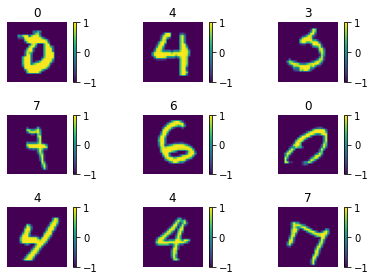

In [7]:
fig1, axs1 = plt.subplots(3, 3)

for i in range(9):
    ax = axs1.flatten()[i]
    im = ax.imshow(images[i].squeeze().numpy())
    plt.colorbar(im, ax=ax)
    ax.set_title(labels[i].item())
    ax.axis('off')
fig1.tight_layout()

# The neural network

## Architecture

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolution step for feature extraction
        self.convolution = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, 1),
            nn.ReLU()
        )
        # Fully connected layers for the end of the network
        self.fully_connected = nn.Sequential(
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Linear(128, 10), # MNIST has 10 categories (digits)
            nn.Softmax(dim=1) # Output the probability
        )

    def forward(self, x):
        x = self.convolution(x) # First goes through the convolutions
        x = torch.flatten(x, 1) # Then reshape (flatten) to go through...
        x = self.fully_connected(x) # ... the fully connected layers
        return x

model_CNN = Net().to(device)

print(model_CNN)

Net(
  (convolution): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)


## Loss and optimizer

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_CNN.parameters(), lr=1e-4, momentum=0.9)

# Training loop

In [10]:
epochs = 10

In [11]:
def train(dl_train, dl_test, model, optimizer, loss_fn, device, epochs):
    
    print('training on {}'.format(device))

    accuracy_test_list = []
    t_list = []

    t_start = timer()

    for i in range(epochs):

        # Adjust the weights using training data
        for j, batch in enumerate(dl_train, 0):

            # Process one batch of images
            X_train, y_train = batch
            X_train = X_train.to(device) # Like our GPU tutorial
            y_train = y_train.to(device)

            # Make predictions
            y_pred = model_CNN(X_train)

            # Loss and adjust the weights
            loss = loss_fn(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Measure accuracy on test data
        test_acc = 0
        with torch.no_grad():
            for j, batch in enumerate(dl_test, 0):

                X_test, y_test = batch
                X_test = X_test.to(device)
                y_test = y_test.to(device)

                # Make predictions
                y_pred = model_CNN(X_test)

                # Measure the accuracy
                total = y_test.size(0)
                correct = \
                    (torch.argmax(y_pred, dim=1) == y_test).sum().item()
                test_acc += correct / total * 100.0
                
        test_acc = test_acc / len(dl_test)
        accuracy_test_list.append(test_acc)

        # Timer for a full epoch
        t_end = timer()
        t_list.append(t_end - t_start)
        print('[{}/{}]\tTest accuracy: {:.1%} (%)'.format(i+1, epochs, test_acc))

    return accuracy_test_list, t_list

In [12]:
accuracy_test_list, t_list = \
    train(dl_train, dl_test, model_CNN, optimizer, loss_fn, device, epochs)

training on cpu
[0/10]	Test accuracy: 24.1 (%)
[1/10]	Test accuracy: 26.7 (%)
[2/10]	Test accuracy: 20.0 (%)
[3/10]	Test accuracy: 18.2 (%)
[4/10]	Test accuracy: 27.7 (%)
[5/10]	Test accuracy: 56.1 (%)
[6/10]	Test accuracy: 78.4 (%)
[7/10]	Test accuracy: 81.4 (%)
[8/10]	Test accuracy: 82.4 (%)
[9/10]	Test accuracy: 83.3 (%)


# Results

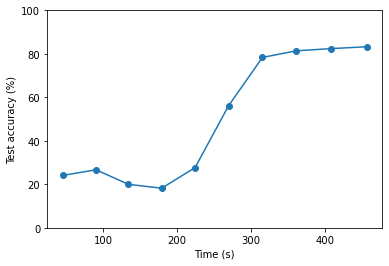

In [13]:
fig1, ax1 = plt.subplots()
ax1.plot(t_list, accuracy_test_list, marker='o')
ax1.set(xlabel='Time (s)', ylabel='Test accuracy (%)', ylim=[0,100])
plt.show()

In [14]:
print('Final accuracy on test data: {:.2f} (%)'.format(accuracy_test_list[-1]))

Final accuracy on test data: 83.27 (%)
